### Simulation of walking trajectories and mapping to collapsed, polar coordinate system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from os.path import sep
from os import mkdir, getcwd
from sys import path

import warnings

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject
from trajectoryAnalysis.periodicWorldAnalysis import collapseTwoObjGrid
from plottingUtilities.basicPlotting import myAxisTheme
from plottingUtilities.flyTracePlots import plotPosInRange

%matplotlib inline 

In [38]:
visitRad = 15
gridSize = 60

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'

objtypeNames = ['Cone','Cylinder']

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

def landmarksInTriangleTile(ax):
    ax.plot(cyliPos[0],cyliPos[1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
    ax.plot(conePos[0],conePos[1], marker='^', markersize=10, alpha=0.8, color=coneColor)
    ax.plot(centerPos[0], centerPos[1], marker='x', markersize=5, alpha=0.8, color='grey')
    ax.set_xlim(-5, gridSize/2 + 5)
    ax.set_ylim(-(gridSize/2+5), (gridSize/2) + 5)
    ax.set_aspect('equal')
    myAxisTheme(ax)
    
def landmarksInSquareTile(ax):
    for obj in range(2):
        ax.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
        ax.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)
    ax.set_xlim(0, gridSize*2)
    ax.set_ylim(-gridSize, gridSize)
    myAxisTheme(ax)
    ax.set_aspect('equal')
    
def visualCheck(ax, param2check, title, colmap):
    cb = ax.scatter(exdf['xt'],exdf['yt'],s=1,c=param2check, cmap=colmap)
    plt.colorbar(cb, ax=ax)
    ax.set_title(title)
    landmarksInTriangleTile(ax)

In [29]:
# Generate trajectory -- simple model

# generate time vector
timePts = int(tEnd/tStep)
time = np.linspace(0,tEnd, timePts)

# initialize positions
x = np.zeros(timePts)
y = np.zeros(timePts)
a = np.zeros(timePts)
x[0], y[0], a[0] = [x0, y0, a0]

for i in range(0,timePts-1):
    
    #update location
    dx = vTrans*np.cos(a[i]) * tStep
    dy = vTrans*np.sin(a[i]) * tStep
    
    da = vRot*np.pi/180 * tStep
    
    x[i+1] = x[i] + dx
    y[i+1] = y[i] + dy
    
    a[i+1] = a[i] + da
    
    #update velocities: smooth changes
    vRot = vRot + aRot
    vTrans = vTrans + aTrans
    
    #turn?
    turnTime = np.random.gamma(gammaShape, scale=gammaShape)
    if turnTime > turnTH:
        turnVal = np.random.normal(loc=0.0, scale=np.pi)
        a[i+1] = a[i+1] + turnVal
        new_vRot = np.random.normal(loc=0.0, scale=5)
        #vRot = -1*np.sign(vRot)*abs(new_vRot)
        vRot = new_vRot
    

In [239]:
# Set simulation parameter
tEnd = 300 #s
tStep = 1/20 #s

x0 = 0
y0 = 0
a0 = np.pi/4

vTrans = 10 #mm/s
aTrans = 0 #mm/s^2

vRot = 2 #deg/s
aRot = 0 #deg/s^2

arrowLength = 0.5*vTrans

# turn prob
gammaShape = 1
gammaScale = 1
turnTH = 3 #threshold

boutL = 10

# color code for time
cNorm  = colors.Normalize(vmin=-2, vmax=tEnd)
mycmap = 'PuBu'#colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [240]:
# Generate trajectory

# generate time vector
timePts = int(tEnd/tStep)
time = np.linspace(0,tEnd, timePts)

# initialize positions
x = np.zeros(timePts)
y = np.zeros(timePts)
a = np.zeros(timePts)
x[0], y[0], a[0] = [x0, y0, a0]
bout = 0

for i in range(0,timePts-1):
    
    #update location
    dx = vTrans*np.cos(a[i]) * tStep
    dy = vTrans*np.sin(a[i]) * tStep
    
    da = vRot*np.pi/180 * tStep
    
    x[i+1] = x[i] + dx
    y[i+1] = y[i] + dy
    
    a[i+1] = a[i] + da
    
    #update velocities: smooth changes
    vRot = vRot + aRot
    if bout <=0:
        aRot = 0
        bout = 0
    else:
        aRot = bout*turnVal/boutL
        bout = bout-1
        
    vTrans = vTrans + aTrans
    
    #turn?
    turnTime = np.random.gamma(gammaShape, scale=gammaScale)
    if turnTime > turnTH:
        turnVal = np.random.normal(loc=0.0, scale=2*np.pi)
        turnVal = -1*np.sign(vRot)*abs(turnVal)
        
        bout = boutL
        aRot = turnVal
        
        #a[i+1] = a[i+1] + turnVal
        new_vRot = np.random.normal(loc=0.0, scale=5)
        vRot = np.sign(turnVal)*abs(new_vRot)
        
        #update gamma shape:
        gammaShape = max(1,5-3*np.log(abs(vRot)))  
        
        vTrans = np.random.gamma(shape=1, scale=0.5) + 0.2*np.random.gamma(shape=9, scale=2)
    

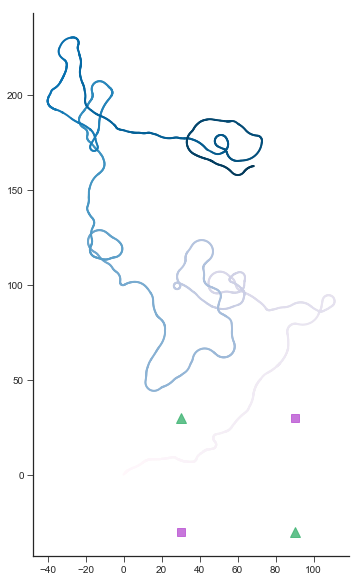

In [241]:
fig, axs = plt.subplots(1,1,figsize=(10,10))

axs.scatter(x,y,s=1,c=time, alpha=0.7, cmap=mycmap)
for obj in range(2):
    axs.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
    axs.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)
myAxisTheme(axs)
axs.set_aspect('equal')

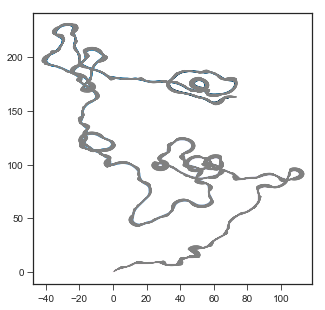

In [242]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(x,y,s=1,c=time, alpha=0.7, cmap=mycmap)

for i, t in enumerate(time):
    if i%100:
        plotBodyAngle(axs, x[i], y[i], a[i],'grey', 1, arrowLength)

In [243]:
gridRepeat = (6.0,5.0) # grid height in repeats of gridSize in x and y
xPosMA, yPosMA = collapseTwoObjGrid(x, y, gridSize, gridRepeat)

In [244]:
xt, yt, anglet, centerPos, conePos, cyliPos = project2triangleTile(xPosMA,yPosMA,a,gridSize)

# Compute parameters in relation to reference landmark (relative to cone or to cylinder)
#     distance from center
r = np.hypot(xt,yt)

#     angular position vector gamma
gamma =  np.sign(yt)*(np.arccos(xt/r))

#     distance to landmark vector: d_cyli, d_cone
#     relative heading angle beta : bt (full range), bht (half range)
#     radial distance r from landmarks: r_cyli = np.hypot(d_cyli[0],d_cyli[1]), r_cone = ...
d_cyli, r_cyli, beta_cyli, betah_cyli, _ = relationToObject(time, xt, yt, anglet, cyliPos)
d_cone, r_cone, beta_cone, betah_cone, _ = relationToObject(time, xt, yt, anglet, conePos)

gamma_cyli =  np.arccos(d_cyli[0]/r_cyli)
gamma_cone =  np.arccos(d_cone[0]/r_cone)

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: deprecated
  if sys.path[0] == '':
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


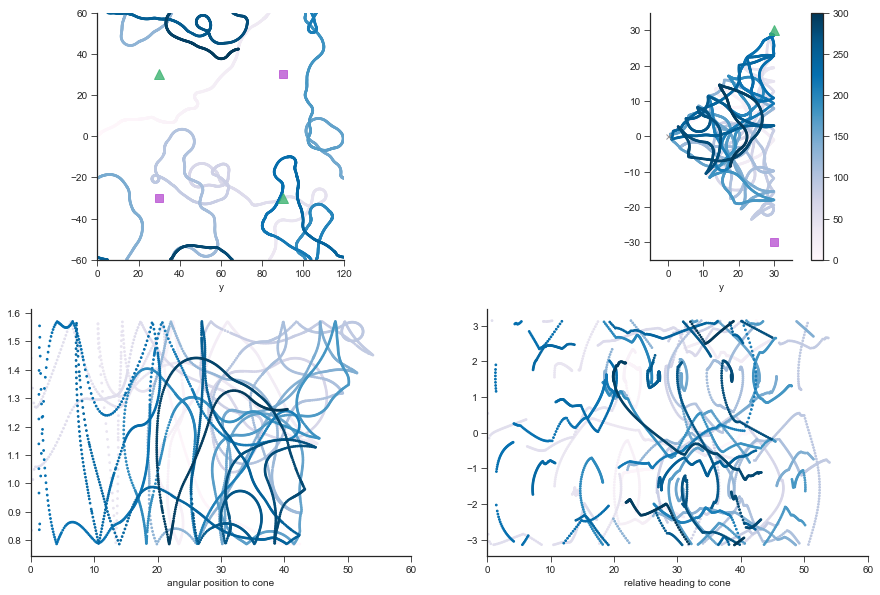

In [248]:
triangleFig, axs = plt.subplots(2,2,figsize=(15,10))

sc = axs[0,0].scatter(xPosMA, yPosMA,s=3,c=time,cmap=mycmap)   
cb = plt.colorbar(sc, ax=axs[0,1])
landmarksInSquareTile(axs[0,0])
axs[0,0].set_xlabel('x')
axs[0,0].set_xlabel('y')

sc = axs[0,1].scatter(xt,yt, s=3, c=time,cmap=mycmap)
landmarksInTriangleTile(axs[0,1])
axs[0,1].set_xlabel('x')
axs[0,1].set_xlabel('y')

sc = axs[1,0].scatter(r_cone,gamma_cone, s=3, c=time,cmap=mycmap)
axs[1,0].set_xlabel('dist to cone')
axs[1,0].set_xlabel('angular position to cone')

sc = axs[1,1].scatter(r_cone,beta_cone, s=3, c=time,cmap=mycmap)
axs[1,1].set_xlabel('dist to cone')
axs[1,1].set_xlabel('relative heading to cone')
for i in range(2):
    myAxisTheme(axs[1,i])
    axs[1,i].set_xlim(0, gridSize)

In [246]:
vT = np.hypot(np.diff(x),np.diff(y))/tStep
vR = np.diff(a)/tStep

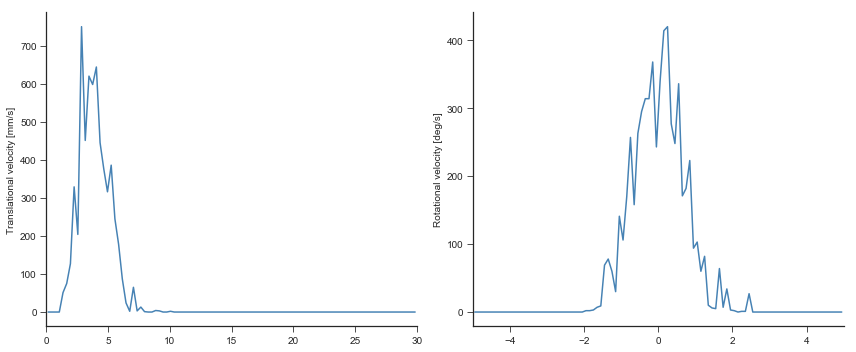

In [247]:
from plottingUtilities.objectInteractionPlots import lineHistogram

vTransTH = 0
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 100
densityFlag = False

walkDistribFig, axs = plt.subplots(1,2,figsize=(12,5))


axs[0], n, edgevt = lineHistogram(axs[0],histRangeVT, vT, '',
                                 'Translational velocity [mm/s]','steelblue', densityFlag, numBins)
axs[1], n, edgevr = lineHistogram(axs[1],histRangeVR, vR, '',
                                 'Rotational velocity [deg/s]','steelblue', densityFlag, numBins)
walkDistribFig.tight_layout()

In [7]:
def plotBodyAngle(ax, x, y, angle, markerColor, alphaVal, arrowScale):

    newArrow = patches.FancyArrow(x, y, np.cos(angle).squeeze()*arrowScale, np.sin(angle).squeeze()*arrowScale,
                                  width=0.25, head_width=0.025,
                                  edgecolor=markerColor, facecolor=markerColor, alpha=alphaVal, linewidth=0.5)
    ax.add_patch(newArrow)
    

In [8]:
def project2triangleTile(x, y, angle, gridSize):
    """ Function to perform projection from square tile to triangle tile. 
        
        Square tile: square zone with 120 mm side length, centered on the center of 
        the square formed by 4 landmarks.
        
        Triangle tile: triangular zone defined by one cone, one cylinder and the center of 
        the square formed by 4 landmarks. The center is positioned at (0,0) and the two 
        landmarks on the right (positive x) of the center position.
    """
    
    warnings.warn("deprecated", DeprecationWarning)
    
    slct = np.arange(0,len(x)) #~np.isnan(x)
    xt = x[slct]
    yt = y[slct]
    anglet = angle[slct]
    
    # (1) cyclic shift of big square ("miniarena")
    yt = (yt + gridSize*1.5)%(gridSize*2)
    
    # (2) cross-project top 2 squares
    leftsquare = np.logical_and(yt > gridSize, xt <= gridSize)
    rightsquare = np.logical_and(yt > gridSize, xt > gridSize)
    
    yt[leftsquare] = yt[leftsquare] - gridSize
    yt[rightsquare] = yt[rightsquare] - gridSize
    
    xt[leftsquare] = xt[leftsquare] + gridSize
    xt[rightsquare] = xt[rightsquare] - gridSize
    
    # (3) flip over the edges of the rectangle parallal to y-axis --> y unchanged, correct heading angle
    tempx = xt.copy()

    xt[tempx < gridSize/2] = abs(gridSize/2 - xt[tempx < gridSize/2]) + gridSize/2
    xt[tempx >= gridSize*1.5] = gridSize*1.5 - abs(gridSize*1.5 - xt[tempx >= gridSize*1.5])
    
    xt = xt - gridSize/2
    
    # recompute angle from flipped vector
    
    #rotate and flip, rotate back
    anglet[tempx < gridSize/2] = -(np.mod(anglet[tempx < gridSize/2] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi
    anglet[tempx >= gridSize*1.5] = -(np.mod(anglet[tempx >= gridSize*1.5] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[np.logical_and(tempx < gridSize/2, angrg)] = \
            anglet[np.logical_and(tempx < gridSize/2, angrg)] + 2*np.pi
    anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] = \
            anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] + 2*np.pi
    
    
    # (4) flip lower triangle onto upper triangle (mirror along y=x diagonal)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[tempx > tempy] = tempy[tempx > tempy]
    yt[tempx > tempy] = tempx[tempx > tempy]

    #rotate and flip, rotate back
    anglet[tempx > tempy] = -(np.mod(anglet[tempx > tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] + 2*np.pi
        
    
    # (5) flip upper right trianlge onto lower left triangle (mirror along y = -x + gridsize axis)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[gridSize - tempx < tempy] = gridSize - tempy[gridSize - tempx < tempy] 
    yt[gridSize - tempx < tempy] = gridSize - tempx[gridSize - tempx < tempy]
    
    # flip parallel to x again before correcting angle
    yt = -yt + gridSize
    anglet = -anglet
    
    #rotate and flip, rotate back
    anglet[gridSize - tempx < tempy] = -(np.mod(anglet[gridSize - tempx < tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] + 2*np.pi
        
    # readjustment of triangle tile for convenience:
    xt = -xt + gridSize/2
    yt = yt - gridSize/2
    
    anglet = -(np.mod(anglet + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[angrg] =  anglet[angrg] + 2*np.pi
    
    # for convenience return the coordinates for the points defining the triangle tile
    centerPos = (0,0)
    conePos = (gridSize/2,gridSize/2)
    cyliPos = (gridSize/2,-gridSize/2)
    
    return xt, yt, anglet, centerPos, conePos, cyliPos